This notebook fits the diffraction geometry + module geometry to a series of powder patterns (with different beam centers)

In [1]:
import time
start = time.time()
import pylab as pl, numpy as np, os
from ImageD11 import transform
from ImageD11.transformer import transformer
from ImageD11.parameters import read_par_file
from ImageD11.columnfile import columnfile
import h5py
import scipy.optimize
import fabio
import pandas as pd
%matplotlib notebook

In [2]:
csv_path = "eigerSpatial/det_pos_reduced.csv"
df = pd.read_csv(csv_path)

<IPython.core.display.Javascript object>


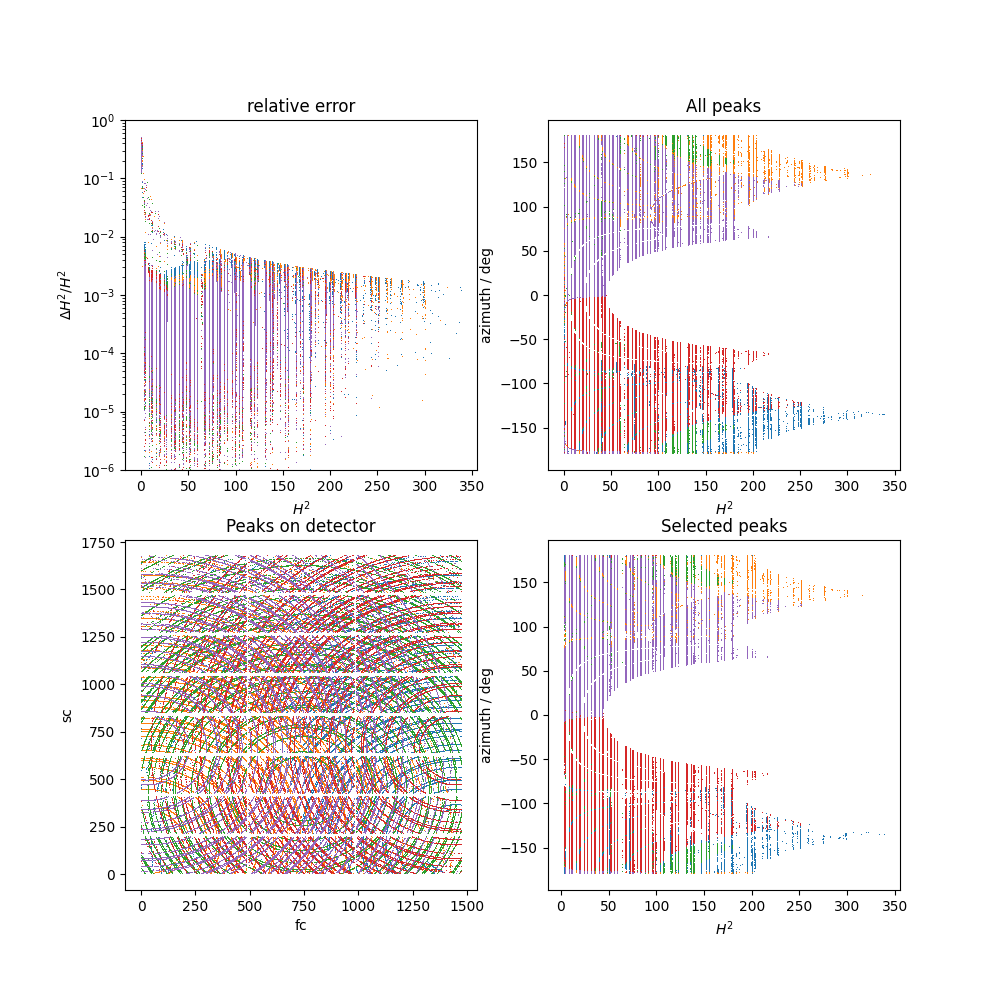

In [5]:
# created via moduleSpatialPeakSearch
f, ((a3, a4),(a1,a2)) = pl.subplots(2,2,figsize=(10,10))
cf = {}
a0 = 5.4113
ds0 = a0*a0
for index, row in df.iterrows():
    i = index + 1
    scan = str(int(row["Scan number"]))
    # Load the peaks and parameters:
    c = columnfile(f'eigerSpatial/{scan}.flt')
    c.parameters.loadparameters(f'eigerSpatial/{scan}-fit.par' )
    c.updateGeometry()
    
    
    # Create column of frame number
    c.addcolumn(np.ones(c.nrows)*i,'frame')
    # (d*_obs)^2 / (a_0)^2 from cubic hkl to d-spacing formula
    c.addcolumn(np.ones(c.nrows)*c.ds**2*ds0,'hkl2')
    # nearest integers == fit target values
    c.addcolumn(np.round(c.hkl2),'ihkl2')
    # something like a strain
    se = abs( c.ihkl2 - c.hkl2 )/np.where( c.ihkl2 > 0, c.ihkl2, 1)
    a3.plot(c.hkl2, se, ",")
    a4.plot(c.hkl2, c.eta, ",")
    # c.filter((c.Number_of_pixels>7) & (c.ihkl2>2) &  (se<1e-2) )
    c.filter((c.Number_of_pixels>4) & (c.ihkl2>2) &  (se<2e-3))
    # c.filter((c.Number_of_pixels>7))
    a1.plot(c.fc,c.sc,',')
    a2.plot(c.hkl2,c.eta,',')
    cf[i] = c
a1.set(title='Peaks on detector', ylabel='sc', xlabel='fc')
a2.set(title='Selected peaks', ylabel='azimuth / deg', xlabel='$H^2$')
a3.set(yscale='log', ylim=(1e-6,1), title='relative error', ylabel='$\Delta H^2/H^2$', xlabel='$H^2$')
_ = a4.set(title='All peaks', ylabel='azimuth / deg', xlabel='$H^2$')


In [6]:
# put together all of the peaks:
allpks = np.concatenate( [cf[f+1].bigarray for f in df.index.values], axis=1)
# ... and place them into an ImageD11 colummfile object
allc = c.copy()
allc.set_bigarray(allpks)
allc.nrows, np.sum([cf[f+1].nrows for f in df.index.values]) 

(219549, 219549)

<IPython.core.display.Javascript object>


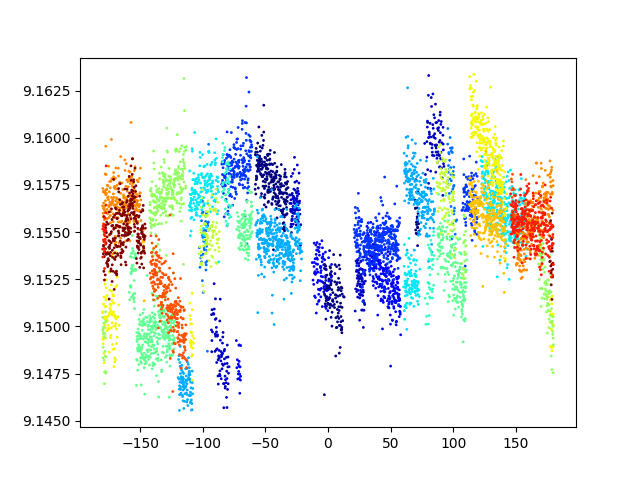

In [7]:
# just one ring, color by module
pl.figure(4)
m = allc.ihkl2 == 3*8
pl.scatter(allc.eta[m],allc.tth[m],c=allc.module[m], s = 1, cmap = 'jet')

In [8]:
frm = np.unique(allc.frame)
modu = np.unique(allc.module)
print(frm, modu)

[1. 2. 3. 4. 5.] [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23.]


In [9]:
# set up a fitting problem : these parameters will be fed to the calchkl2 routine below

# distance, tilts, centers for each image 
pars = [ ]
pnames = [ ]
for f in frm:
    pars.append( cf[f].parameters.get('distance') / a0 ) # distance scaled on lattice
    pnames.append( '%d:distance/a'%(f) )
    for pname in 'y_center z_center tilt_y tilt_z'.split():
        pars.append( cf[f].parameters.get(pname) )
        pnames.append( '%d:%s'%(f, pname) )

pars.append( a0 ) # effectively the wavelength
pnames.append( 'a0' )
framepars = len(pars)
nframes = len(cf.keys())
pars += [0. for i in range(23*3)] # 24 module centers and tilts, BUT LAST IS FIXED
pnames += ["M[%d,%d]"%(i,j) for i in range(23) for j in range(3) ]
for n,v in zip(pnames, pars):
    print(n,v)
# offset, rotation for each module

1:distance/a 95090.77696206799
1:y_center 1449.2360019304924
1:z_center 167.4062146545098
1:tilt_y 0.002160873607698035
1:tilt_z -0.0004025483936460982
2:distance/a 94858.57116207854
2:y_center 24.855186969809324
2:z_center 167.38191529458481
2:tilt_y -0.00011326603689301238
2:tilt_z -0.0006989128599699851
3:distance/a 94915.11576566426
3:y_center 739.622757228833
3:z_center 446.9272639925752
3:tilt_y -0.0001194747233954405
3:tilt_z 0.002009090333035848
4:distance/a 94982.20511229466
4:y_center 1448.0823048434108
4:z_center 661.944591832296
4:tilt_y -0.0002728113384936364
4:tilt_z 0.0020054753186083667
5:distance/a 94896.0967574297
5:y_center 24.273929056412317
5:z_center 661.8541640665684
5:tilt_y -0.00031926367713809177
5:tilt_z 0.0014298373990559218
a0 5.4113
M[0,0] 0.0
M[0,1] 0.0
M[0,2] 0.0
M[1,0] 0.0
M[1,1] 0.0
M[1,2] 0.0
M[2,0] 0.0
M[2,1] 0.0
M[2,2] 0.0
M[3,0] 0.0
M[3,1] 0.0
M[3,2] 0.0
M[4,0] 0.0
M[4,1] 0.0
M[4,2] 0.0
M[5,0] 0.0
M[5,1] 0.0
M[5,2] 0.0
M[6,0] 0.0
M[6,1] 0.0
M[6,2] 

In [10]:
def module(a,i,j):
    #p = padding around the outside for debug
    fs = 486
    ss = 194
    fo = [0, 8, 2*8]
    so = [0, 18, 2*18, 3*18, 4*18, 5*18, 6*18, 7*18]
    f = fs*j + fo[j]
    s = ss*i + so[i]
    return a[s:s+ss,f:f+fs]

def module_center( i, j ):
    fs = 486
    ss = 194
    fo = np.array([0, 8, 2*8])
    so = np.array([0, 18, 2*18, 3*18, 4*18, 5*18, 6*18, 7*18])
    # print(i.dtype,j.dtype,j.shape)
    return so[i] + ss*(i+0.5), fo[j] + fs*(j+0.5)

def mp23_24( p23 ):
    """ Compute the parameters of module 24 from the other 23
    We set the sum of all 24 to be zero
    """
    p24 = np.array(list(p23) + [0,0,0]).reshape( (24, 3) ) 
    p24[-1,:] = -np.sum(p24, axis=0) # last module is fixed to make mean zero
    return p24
    
    
def do_spatial(s_raw, f_raw, m, modpars):
    """
    s_raw = co-ordinate in the slow pixel direction
    f_raw = co-ordinate in the fast pixel direction
    m = module for this peak (in the range 0,24 for Pilatus CdTe)
    modpars = spatial parameters (offset_slow, offset_fast, angle_rad)
    """
    i = m // 8
    j = m % 3
    cs, cf = module_center( i, j )
    shift_s = np.array( modpars[:,0] )
    shift_f = np.array( modpars[:,1] )
    ds = s_raw[:] - cs + shift_s[m]
    df = f_raw[:] - cf + shift_f[m]
    rotates = modpars[:,2]
    sinr = np.sin(rotates)
    cosr = np.cos(rotates)
    dsr =  cosr[m] * ds  + sinr[m] * df
    dfr = -sinr[m] * ds  + cosr[m] * df
    sc = dsr + cs
    fc = dfr + cf
    return sc,fc    

def calchkl2( colf, *args ):
    """
    colf = columnfile (table) containing labelled peaks
    *args = parameters to be fitted
    """
    fpars = np.array(list(args))
    global framepars, frm # above
    modpars = mp23_24(fpars[framepars:]) # make last module == sum of previous
    #
    ycalc = np.zeros(colf.nrows, float)
    # apply the current spatial correction
    m = colf.module[:].astype(int)
    sc, fc = do_spatial( colf.s_raw, colf.f_raw, m, modpars )
    w = 0.1763
    a0 = fpars[framepars-1]
    for k,rf in enumerate(frm):
        f = int(rf)
        lo = np.searchsorted( colf.frame, f )   # assume data still sorted by frame
        hi = np.searchsorted( colf.frame, f+1 )
        # compute x,y,z laboratory
        x,y,z = transform.compute_xyz_lab( (sc[lo:hi], fc[lo:hi]), 
                                               distance = fpars[k*5]*a0, # take out ds0 again
                                               y_center = fpars[k*5+1],
                                               z_center = fpars[k*5+2],
                                               y_size=0.172, z_size=0.172,
                                               tilt_y = fpars[k*5+3],
                                               tilt_z = fpars[k*5+4],
                                               tilt_x = 0,
                                               o11=-1,o12=0,o21=0,o22=-1 )
        # radius:
        r = np.sqrt(y*y + z*z)
        # two theta:
        tthrad = np.arctan2(r, x)
        # wvln = 2*d*sin(th)
        # 1/d = 2*sin(th)/wvln
        # c.ds**2*ds0
        ds = 2*np.sin( tthrad/2 ) / w
        ycalc[lo:hi] = ds*ds*a0*a0
    scor = np.mean((ycalc - colf.ihkl2)**2)
    strain = (ycalc - colf.ihkl2)/colf.ihkl2  # approximately zero
    return strain

<IPython.core.display.Javascript object>


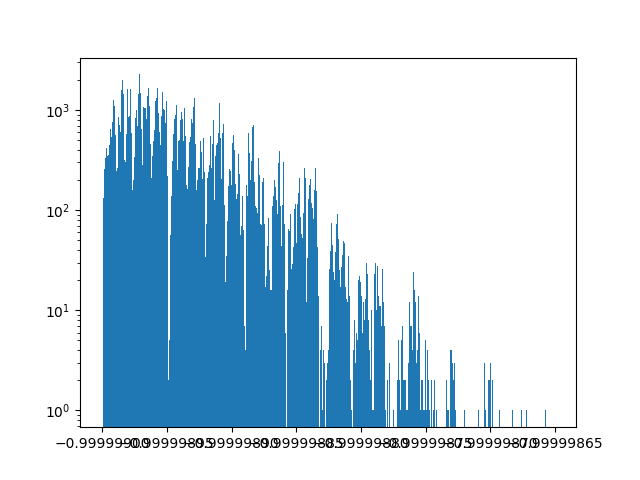

In [11]:
yc = calchkl2( allc, *pars )
pl.figure()
pl.hist(yc,bins=1024)
pl.semilogy()
pl.ticklabel_format(useOffset=False, style="plain", axis="x")

In [ ]:
avgi = allc.sum_intensity / allc.Number_of_pixels   # average intensity in a peak 
sigma = avgi/avgi.max()                             # relative weights

fpars, matrx = scipy.optimize.curve_fit( calchkl2,               # function to fit
                               allc,                    # 'x' argument to function 
                               np.zeros(allc.nrows),    # y_obs values (integer hkls)  
                               pars,                    # parameters to be fitted
                               sigma = sigma  )

In [ ]:
#print(fpars, matrx)
pl.figure()
corr = matrx.copy()
ser = np.sqrt(np.diag(corr))
corr = corr / ser 
corr = corr.T / ser
pl.imshow(corr, cmap='gist_ncar', vmin=-1)
pl.colorbar()
pl.title("correlation matrix")
print("Correlation above 80%")
for i in range(corr.shape[0]):
    for j in range(i-1):
        if abs(corr[i,j])>0.8:
            print(pnames[i],pnames[j],corr[i,j])

In [ ]:
ycalc = calchkl2(allc, *fpars)
pl.figure()
pl.plot(allc.eta, ycalc*allc.ihkl2+allc.ihkl2, ",")
pl.figure()
pl.plot(allc.eta, ycalc, ",")
pl.figure()
pl.hist( ycalc, bins=1024)
pl.semilogy()

In [ ]:
allc.filter( abs(ycalc)<0.0003 )

In [ ]:
ycalc = calchkl2(allc, *fpars)
pl.figure()
pl.plot(allc.Number_of_pixels,ycalc,'.', alpha=0.01)

In [ ]:
# repeat fitting with cleaned data
p2 = [p for p in fpars]  
fpars2, matrx2 = scipy.optimize.curve_fit( calchkl2, allc, np.zeros(allc.nrows), p2 )

In [ ]:
p16 = mp15_16(fpars2[framepars:])

In [ ]:
np.savetxt("fitted_eiger_pars2.dat",fpars2)
np.savetxt("fitted_eiger_framepars2.dat",p16)

In [ ]:
# Write spatially corrected files
a0 = fpars2[framepars-1]
for i in range(1,5):
    p = read_par_file("eigerSpatial/%d.par"%(i))
    k = i-1
    p.parameters.update( {'distance' : fpars2[k*5]*a0,
                          'y_center' : fpars2[k*5+1],
                          'z_center' : fpars2[k*5+2],
                          'tilt_y' : fpars2[k*5+3],
                          'tilt_z' : fpars2[k*5+4] } )
    p.saveparameters("eigerSpatial/%ds.par"%(i))

In [ ]:
# Verify and create conventional distortion files
s, f = np.mgrid[0:2162,0:2068]
m = np.zeros(s.shape, np.int)-1
#    fs = 513
#    ss = 512
#    fo = [0,2,14,16]
#    so = [0,38,2*38,38*3]
for i in range(4):
    for j in range(4):
        a = module(m,i,j)
        a[:,:] = i*4+j
# Make an image of which module is this pixel
# fill gaps: ... yes, this could be more elegant
m[512:512+38//2,:]=m[511,:]
m[512+38//2:512+38,:]=m[512+39,:]
m[512*2+38:512*2+38+38//2,:]=m[512*2+38-1,:]
m[512*2+38+38//2:512*2+38*2,:]=m[512*2+2+38+1,:]
m[512*3+38*2:512*3+38*2+38//2,:]=m[512*3+38*2-1,:]
m[512*3+38*2+38//2:512*3+38*3,:]=m[512*3+3*38+1,:]
m[:,513]=m[:,512]
m[:,514]=m[:,515]
m[:,-514]=m[:,-513]
m[:,-515]=m[:,-516]
m[:,1027:1034]=m[:,1025][:,np.newaxis]
m[:,1034:1040]=m[:,1041][:,np.newaxis]
# verify we did not mess up the real pixels:
for i in range(4):
    for j in range(4):
        a = module(m,i,j)
        assert((a[:,:] == i*4+j).all())
pl.figure()
pl.imshow(m)
pl.colorbar()

In [ ]:
# full image spatial:
sc,fc = do_spatial(s.ravel(),f.ravel(),m.ravel(), p16)
sc.shape=s.shape
fc.shape=f.shape
ds = sc - s      # LUT
df = fc - f      # 

In [ ]:
fabio.edfimage.edfimage((fc-f).astype(np.float32)).write("e2dx.edf")
fabio.edfimage.edfimage((sc-s).astype(np.float32)).write("e2dy.edf")

In [ ]:
# convert this spatial distortion in pyFAI format - original file came from J. Kieffer grid fit.
pyFAIspatial = "/data/id11/nanoscope/Eiger/Eiger2CdTe_4M_ID11.h5"
with h5py.File(pyFAIspatial,'r') as h:
    x = h['entry_0000/pyFAI/Eiger2_CdTe_4M/pixel_corners'][:]
    print(x.shape, x[-1,-1])

In [ ]:
os.system('cp ' + pyFAIspatial + ' newSpatial.h5' )

In [ ]:
ps = 7.5e-5
with h5py.File('newSpatial.h5','r+') as h:
    x = h['entry_0000/pyFAI/Eiger2_CdTe_4M/pixel_corners'][:]
    sc,fc = do_spatial(s.ravel()-0.5,f.ravel()-0.5,m.ravel(), p16)
    sc=np.reshape(sc,s.shape)
    fc=np.reshape(fc,f.shape)
    x[:,:,0,1] = sc*ps
    x[:,:,0,2] = fc*ps

    sc,fc = do_spatial(s.ravel()+0.5,f.ravel()-0.5,m.ravel(), p16)
    sc=np.reshape(sc,s.shape)
    fc=np.reshape(fc,f.shape)
    x[:,:,1,1] = sc*ps
    x[:,:,1,2] = fc*ps

    sc,fc = do_spatial(s.ravel()+0.5,f.ravel()+0.5,m.ravel(), p16)
    sc=np.reshape(sc,s.shape)
    fc=np.reshape(fc,f.shape)
    x[:,:,2,1] = sc*ps
    x[:,:,2,2] = fc*ps

    sc,fc = do_spatial(s.ravel()-0.5,f.ravel()+0.5,m.ravel(), p16)
    sc=np.reshape(sc,s.shape)
    fc=np.reshape(fc,f.shape)
    x[:,:,3,1] = sc*ps
    x[:,:,3,2] = fc*ps
    h['entry_0000/pyFAI/Eiger2_CdTe_4M/pixel_corners'][:]=x

In [ ]:
t = transformer()
t.loadfiltered("eigerSpatial/1.flt")
c = t.colfile
c.sc[:] = ds[np.round( c.s_raw[:].astype(int) ), np.round( c.f_raw[:].astype(int) ) ] + c.s_raw[:]
c.fc[:] = df[np.round( c.s_raw[:].astype(int) ), np.round( c.f_raw[:].astype(int) ) ] + c.f_raw[:]
t.loadfileparameters("eigerSpatial/1s.par")
t.compute_tth_eta()
t.addcellpeaks()
t.parameterobj.varylist.append('wavelength')
t.fit()

In [ ]:
t.fit_tolerance=0.005
for i in range(3):
    t.addcellpeaks() 
    t.fit()
    t.compute_tth_eta()
t.addcellpeaks() # wavelenght is fitted

In [ ]:
pl.figure()
pl.plot(t.colfile.tth,t.colfile.eta,",")
pl.plot(t.theorytth,np.zeros(len(t.theorytth)),"|",ms=180,alpha=0.2)

In [ ]:
12.3985/t.parameterobj.parameters['wavelength']

In [ ]:
h,b = np.histogram(c.tth,weights=c.sum_intensity,bins=np.arange(0,c.tth.max(),0.0001))
pl.figure()
pl.plot(b[1:],h,'+-')
f,a=pl.subplots(1,8,figsize=(12,4))
for i,tth in enumerate(t.theorytth[:8]):
    lo = np.searchsorted(b,tth-0.002)
    hi = np.searchsorted(b,tth+0.002)
    a[i].plot( b[lo:hi], h[lo:hi], "+-" )

In [ ]:
c.parameters = t.parameterobj

In [ ]:
c.updateGeometry()

In [ ]:
c.titles
r = np.arctan2(np.sqrt(c.yl*c.yl+c.zl*c.zl), c.xl)*c.xl.mean()/0.075
pl.figure()
pl.plot(c.eta,r,",")
rcalc = np.zeros(r.shape,np.float)
lines = ["tth   npks    rad_mean    rad_std    Median_abs_dev  Mean_abs_dev",]
for tth in t.theorytth:
    sel = np.abs(c.tth - tth)<0.005
    pks = r[sel]
    if sel.sum()==0:
        continue
    rc = pks.mean()
    mad = np.median(abs(r[sel] - rc))
    msel = np.abs( r - rc ) < mad * 3
    pks = r[msel]
    rc = r[msel].mean()
    pl.figure()
    pl.plot( c.eta[sel], r[sel], '.', ms=1 )
    pl.plot( c.eta[msel], r[msel], '.r', ms=1 )
    pl.plot( (-180, 180), [rc, rc], '-', lw=1 )
    pl.ylim(rc-0.5, rc+0.5)
    ad = abs(pks-pks.mean())
    lines.append("%.5f %5d %.3f %.3f %.3f %.3f"%(
        tth,msel.sum(),pks.mean(),pks.std(),np.median(ad),np.mean(ad)))
for line in lines:
    print(line)

In [ ]:
print("Output created on %s"%(time.ctime()))
print("Total runtime %.3f /s"%(time.time()-start))